# 利用numpy实现多层神经网络单车预测器

  本文基于国外的共享单车公开数据集（Capital Bikeshare），利用numpy构建了一个多层的神经网络的单车预测器，用来预测某一时间、某一停放区域的单车数量，供共享单车公司参考，以实现对单车的合理投放。主要内容有：

1. 该单车预测器的网络结构为多层全连接神经网络，每层神经元数目可以进行自定义设置，激活函数为sigmoid函数。
2. 数据输入为56个特征，包含星期几、是否节假日、温度、湿度等属性。
3. 参数更新运用梯度下降法，其中梯度计算利用反向传播算法进行。
4. 训练过程采用了批处理
5. 对最后一个月的数据进行了预测
6. 对单层、双层、三层神经网络进行了简单的比较



In [901]:
#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt

# 让输出的图形直接在Notebook中显示
%matplotlib inline

## 一、数据预处理

首先导入单车数据集，并对数据进行预处理工作。

In [902]:
#读取数据到内存中，rides为一个dataframe对象
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

### 1. 将类型变量进行one-hot编码

有很多变量都属于类型变量，例如season=1,2,3,4，分四季。我们不能将season变量直接输入到神经网络，这是因为season数值越高并不表示相应的信号强度越大。我们的解决方案是将类型变量用一个“一位热码“（one-hot）来编码，也就是：

$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有n个不同取值，那么我们的“一位热码“所对应的向量长度就为n

In [903]:
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #利用pandas对象，我们可以很方便地将一个类型变量属性进行one-hot编码，变成多个属性
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

### 2. 将数值类型变量进行标准化
由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系，为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。比如，对于温度temp这个变量来说，它在整个数据库取值的平均着为mean(temp), 方差为std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

In [904]:
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
#quant_features = ['temp', 'hum', 'windspeed']

# 我们将每一个变量的均值和方差都存储到scaled_features变量中。
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 3. 将数据集进行分割
将数据集分为测试集与训练集

In [905]:
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列

#目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)


Y = np.reshape(Y, [len(Y),1])
losses = []

训练数据： 16875 测试数据： 504


In [906]:
features#.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16870,1,0,-0.088219,0.999178,0.764282,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16871,1,0,-0.192085,1.310171,0.764282,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16872,1,0,0.119512,0.740016,0.764282,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
16873,1,0,-0.192085,1.310171,0.519881,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


## 二. 利用numpy构建神经网络

### 1. 参数初始化

In [907]:
def init_params(nn_architecture,seed = 99): 
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    #读取各层参数
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx+1
        
        print(layer)
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        #设置W初始化参数
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size)* 0.1
       #设置b初始化参数
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
       

    return params_values

### 2. 设置激活函数
该神经网络的激活函数为sigmoid函数，利用numpy写出其函数定义与导数。

$ sigmoid(Z)=\frac{1}{1+exp(-Z)}$

输出层为一个没有激活函数的线性层，为了代码的书写统一与函数调用，设置激活函数“none”，即没有激活函数，供输出层使用。

In [908]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_back(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def none(Z):
    return Z

def none_back(dA, Z):
    dZ = np.array(dA, copy = True)
    return dZ

### 3. 定义损失函数MSE

In [909]:
def get_cost_value(Y_hat, Y):
    cost= np.mean((Y_hat - Y) ** 2)
    return np.squeeze(cost)

### 4. 前向传播
![前向传播](./前向1.png)

In [910]:
#设置单层神经元的前向传播计算过程
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    
    #计算Z=W*A+b
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "none":
        activation_func = none  
    else:
        raise Exception('Non-supported activation function')
        
    #返回值为 激活函数*Z 与 Z
    return activation_func(Z_curr), Z_curr

In [911]:
#设置整个神经网络的前向传播计算
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    #第一层的A即为输入X
    A_curr = X

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr

        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        #保存A与Z的值
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    return A_curr, memory

### 5. 反向传播
梯度计算分为两部分
#### a.计算$\frac{\partial z}{\partial w}$（Forward pass的部分）

forward pass的运算规律是：

$\frac{\partial z}{\partial w_1} = x_1 $ 

$ \frac{\partial z}{\partial w_2} = x_2$
#### b.计算$\frac{\partial C}{\partial z}$ ( Backward pass的部分 )
从神经网络最后一层往前传，依次计算导数


In [912]:
#定义单个layer的反向传播
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    m = A_prev.shape[1]

    if activation is "sigmoid":
        backward_activation_func = sigmoid_back
    elif activation is "none":
        backward_activation_func= none_back
    else:
        raise Exception('Non-supported activation function')

    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [913]:
#定义整个网络的反向传播
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    grads_values.clear()
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)

    dA_prev =Y_hat-Y  #cost对于Y的导数

    #将nn_architecture进行reverse，从最底层开始计算导数
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    #返回所有参数的梯度值
    return grads_values

### 6. 参数更新
根据梯度下降，对参数W与b进行参数更新

$ \ θ= θ-α*▽L $

In [914]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        
        #W与b皆为从W1、b1开始
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    #返回更新后的参数
    return params_values;

## 三. 训练
将train_data输入进神经网络，进行计算。
为了提高训练质量，使用batch_size进行分批次训练。

Batch Size设置合适时的优点：

1. 通过并行化提高内存的利用率，提高训练速度。
2. 单个epoch的迭代次数减少了，参数的调整也慢了，假如要达到相同的识别精度，需要更多的epoch。
3. 适当Batch Size使得梯度下降方向更加准确。

In [915]:
#定义训练函数
def train(X, Y, nn_architecture, epochs, learning_rate,batch_size):
    #输入初始化参数
    params_values = init_params(nn_architecture)
    losses=[]

    #神经网络训练循环
    for i in range(epochs):
        
        # 每batch_size个样本点被划分为一个撮，在循环的时候一批一批地读取
        batch_loss = []
        for start in range(0, len(X), batch_size):
            end = start + batch_size if start + batch_size < len(X) else len(X)
            XX = X[start:end]
            #print(XX.shape)
            XX=np.transpose(XX)
            YY = Y[start:end]
            YY=np.transpose(YY)
             
            Y_hat, cashe = full_forward_propagation(XX, params_values, nn_architecture)
            #print(Y_hat)
            cost = get_cost_value(Y_hat, YY)
            #print(cost)
            batch_loss.append(cost)
                
            grads_values = full_backward_propagation(Y_hat, YY, cashe, params_values, nn_architecture)
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        # 每隔100步输出一下损失值（loss）
        if i % 100==0:
            losses.append(np.mean(batch_loss))
            print(i, np.mean(batch_loss)) 
    
    #返回最终的参数值，用以预测
    return params_values

#### 自定义网络个数与参数
本文选择隐藏层为两层，神经元数量分别为6与4

In [916]:
nn_architecture = [
    {"input_dim": features.shape[1], "output_dim":6, "activation": "sigmoid"},
    {"input_dim": 6, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "none"},]

进行训练，设置epochs为2000，学习率为0.01，batch_size为128

In [917]:
params_values=train(X,Y, nn_architecture,2000, 0.01,128)

{'input_dim': 56, 'output_dim': 6, 'activation': 'sigmoid'}
{'input_dim': 6, 'output_dim': 4, 'activation': 'sigmoid'}
{'input_dim': 4, 'output_dim': 1, 'activation': 'none'}
0 0.9737285702370855
100 0.9987043020844
200 0.6662042553935706
300 0.2757910494320029
400 0.252849800157505
500 0.2327053272169614
600 0.1895773628648771
700 0.14404410166193887
800 0.11206213294112387
900 0.09242752147066449
1000 0.08156035617304988
1100 0.07553735601925267
1200 0.07190278525588069
1300 0.06946703468735982
1400 0.06766391603442795
1500 0.06622034080252291
1600 0.06500576907221599
1700 0.06395944823826617
1800 0.06305221330675355
1900 0.06226653398852889


Text(0, 0.5, 'MSE')

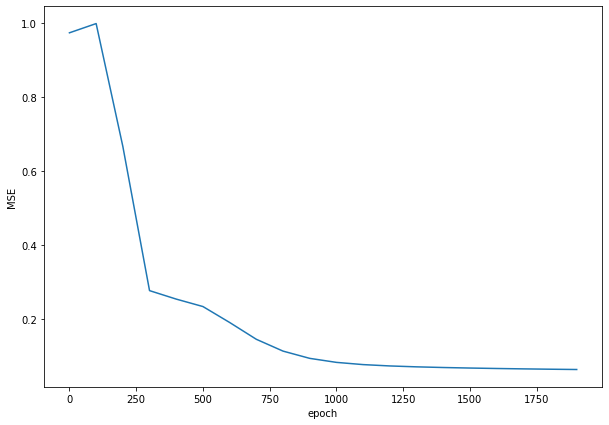

In [918]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

由上图"损失函数—训练周期"可以看出，平均误差随训练周期快速下降。

## 四、进行预测
将数据集的后21天的数据输入到训练好的网络中，并将输出值与y进行比较

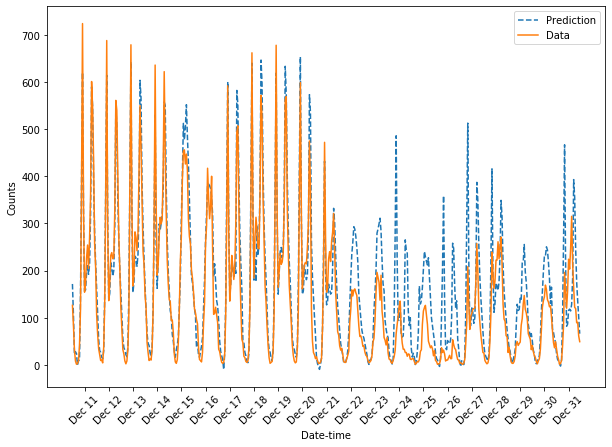

In [923]:
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt'] #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1]) #将数据转换成合适的tensor形式
targets = targets.astype(float) #保证数据为实数

# 将属性和预测变量包裹在Variable型变量中
x = test_features.values
y = targets

# 用神经网络进行预测
predict= full_forward_propagation(np.transpose(x), params_values, nn_architecture)[0]
predict=predict.flatten()

#print((predict * std + mean)[:10])

# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle = '--')
ax.plot(targets * std + mean, label='Data', linestyle = '-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

实际曲线与预测曲线的对比上图所示。其中，横坐标是不同的日期，纵坐标是预测或真实数据的值。虚线为预测曲线，实线为实际数据。

可以看出，本神经网络拟合的曲线与实际曲线在12月25之前基本相符，但是在12㛑25日之后有较大的出入，分析可知，这是因为12月25日好是圣诞节。在圣诞节假期前后，人们的出行习惯会与往日相比会有所升高。

产生这一偏差的原因是我们的训练样本中，对于圣诞节前后的情况样本太少，使得神经网络不能有效学习该类情况。为了提高预测准确率，可以增加该类样本数量，供神经网络学习。

##  五、单层神经网络与多层神经网络简单对比
固定隐藏层神经元总个数为10，分别进行单层（10）、双层（6+4）、三层（5+3+2）的神经网络训练

### 1、单层（10）

{'input_dim': 56, 'output_dim': 10, 'activation': 'sigmoid'}
{'input_dim': 10, 'output_dim': 1, 'activation': 'none'}
0 0.942079519144533
100 0.30640460259717295
200 0.272788170242938
300 0.2574819693912492
400 0.24035811174333024
500 0.21958651123170708
600 0.193510093480868
700 0.16179848205088385
800 0.13493336239562229
900 0.113979754587197
1000 0.09813208841411973
1100 0.08664425581236733
1200 0.07859268845098859
1300 0.07300235465395681
1400 0.0691245056087082
1500 0.06642131110316336
1600 0.06450658362194162
1700 0.06311352926324511
1800 0.06206579076469227
1900 0.0612496454877047


Text(0, 0.5, 'MSE')

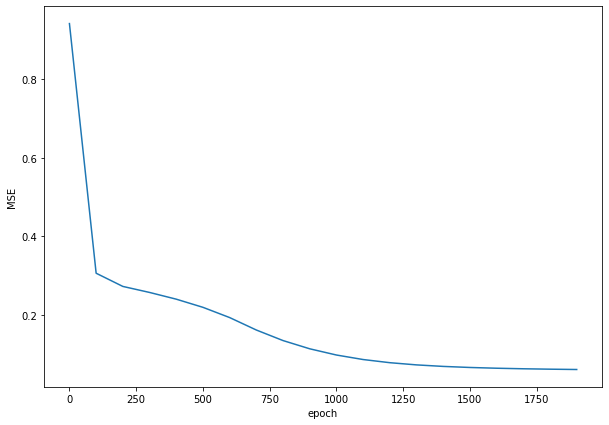

In [926]:
losses=[]
nn_architecture = [
    {"input_dim": features.shape[1], "output_dim":10, "activation": "sigmoid"},
    {"input_dim":10, "output_dim": 1, "activation": "none"},]
params_values=train(X,Y, nn_architecture,2000, 0.01,128)
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

上图为单层神经网络的"损失函数—训练周期"图，可以看出其平均误差随训练周期快速下降，与双层神经网络一的下降速度大致相同，且训练效果相差不大。

### 2、三层（5+3+2）

{'input_dim': 56, 'output_dim': 5, 'activation': 'sigmoid'}
{'input_dim': 5, 'output_dim': 3, 'activation': 'sigmoid'}
{'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}
{'input_dim': 2, 'output_dim': 1, 'activation': 'none'}
0 0.9807332652935354
100 1.0030138193143043
200 1.003090741928494
300 1.0031655340244015
400 1.003238218523465
500 1.0033088191952353
600 1.0033773599971079
700 1.0034438643254824
800 1.0035083541398782
900 1.0035708489049826
1000 1.0036313642709724
1100 1.0036899103750592
1200 1.0037464895893113
1300 1.0038010934481734
1400 1.0038536983405826
1500 1.0039042593046497
1600 1.0039527008403004
1700 1.0039989029089131
1800 1.0040426789224073
1900 1.0040837399181013


Text(0, 0.5, 'MSE')

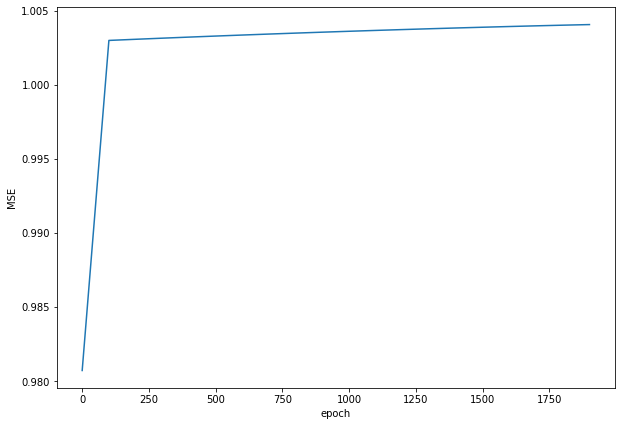

In [927]:
losses=[]
nn_architecture = [
    {"input_dim": features.shape[1], "output_dim":5, "activation": "sigmoid"},
    {"input_dim": 5, "output_dim": 3, "activation": "sigmoid"},
    {"input_dim": 3, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "none"},]

params_values=train(X,Y, nn_architecture,2000, 0.01,128)
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

上图为三层神经网络的"损失函数—训练周期"图，可以看出其平均误差随训练周期并未下降，这可能是产生了梯度消失的问题，可能与sigmoid函数性质有关。

由此简单的对比可以看出，随着深度的增加，在训练sigmoid神经网络时，应注意梯度消失的问题。